In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import h5py
import seaborn as sns
from scipy.special import logit
from scipy.special import expit
from scipy.interpolate import RegularGridInterpolator
from pylab import rcParams
import sys
import torch
import scipy
import corner
import copy
from copy import deepcopy

import sys
sys.path.append('../')
from populations.bbh_models import read_hdf5
from populations.bbh_models import get_models
from populations.Flowsclass_dev import FlowModel
from populations.utils.bounded_Nd_kde import Bounded_Nd_kde

/data/wiay/2297403c/conda_envs/amaze/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#flags/inputs:
param = ['mchirp','q', 'chieff', 'z']
no_params = len(param)
channel_label = 'SMT'

channel_ids = {'CE':0, 'CHE':1,'GC':2,'NSC':3, 'SMT':4}
channel_id = channel_ids[channel_label] #will be 0, 1, 2, 3, or 4
chi_b = [0.0,0.1,0.2,0.5]
alpha_CE = [0.2,0.5,1.0,2.,5.]
channel_samples = [4e6,864124,896611,582961, 4e6]
no_binaries = int(channel_samples[channel_id])
batch_size = 10000
total_hps=20

models_path ='/data/wiay/2297403c/models_reduced.hdf5'
#models_path ='/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/testing_notebooks/flow_samples.hdf5'
popsynth_outputs = read_hdf5(models_path, channel_label) # read all data from hdf5 file

models_dict = dict.fromkeys(popsynth_outputs.keys())
weights_dict = dict.fromkeys(popsynth_outputs.keys())


for key in popsynth_outputs.keys():
    models_dict[key] = popsynth_outputs[key][param]
    weights_dict[key]= popsynth_outputs[key]['weight']


In [4]:
#check that these distributions are the same between the whole (transformed distribution), batch, and the same for validation data
#no_trans, no_neurons, training_inputs, cond_inputs,no_binaries, batch_size, total_hps, RNVP=True, num_bins=4, device="cpu"):
no_bins=4
flow1 = FlowModel(channel_label, popsynth_outputs, param, no_bins=no_bins, no_neurons=164)
flow2 = FlowModel(channel_label, popsynth_outputs, param, no_bins=no_bins, no_neurons=128)

#_, KDE_models_detectable = get_models(models_path, [channel_label], param, use_flows=False, spin_distr=None, sensitivity='midhighlatelow_network', normalize=False, detectable=True)


In [5]:
flow1.load_model('../rns/Flows_040924_trainlogalpha/flow_models/', channel_label)
flow2.load_model('../rns/Flows_210524_scatter/flow_models/flow_models/', channel_label)


/tmp/ipykernel_3266186/3059401312.py:39: UserWarning: The figure layout has changed to tight
  fig_mchirp.tight_layout(pad=1.3)
/tmp/ipykernel_3266186/3059401312.py:40: UserWarning: The figure layout has changed to tight
  fig_c.tight_layout(pad=1.3)
/tmp/ipykernel_3266186/3059401312.py:41: UserWarning: The figure layout has changed to tight
  fig_q.tight_layout(pad=1.3)
/tmp/ipykernel_3266186/3059401312.py:42: UserWarning: The figure layout has changed to tight
  fig_z.tight_layout(pad=1.3)


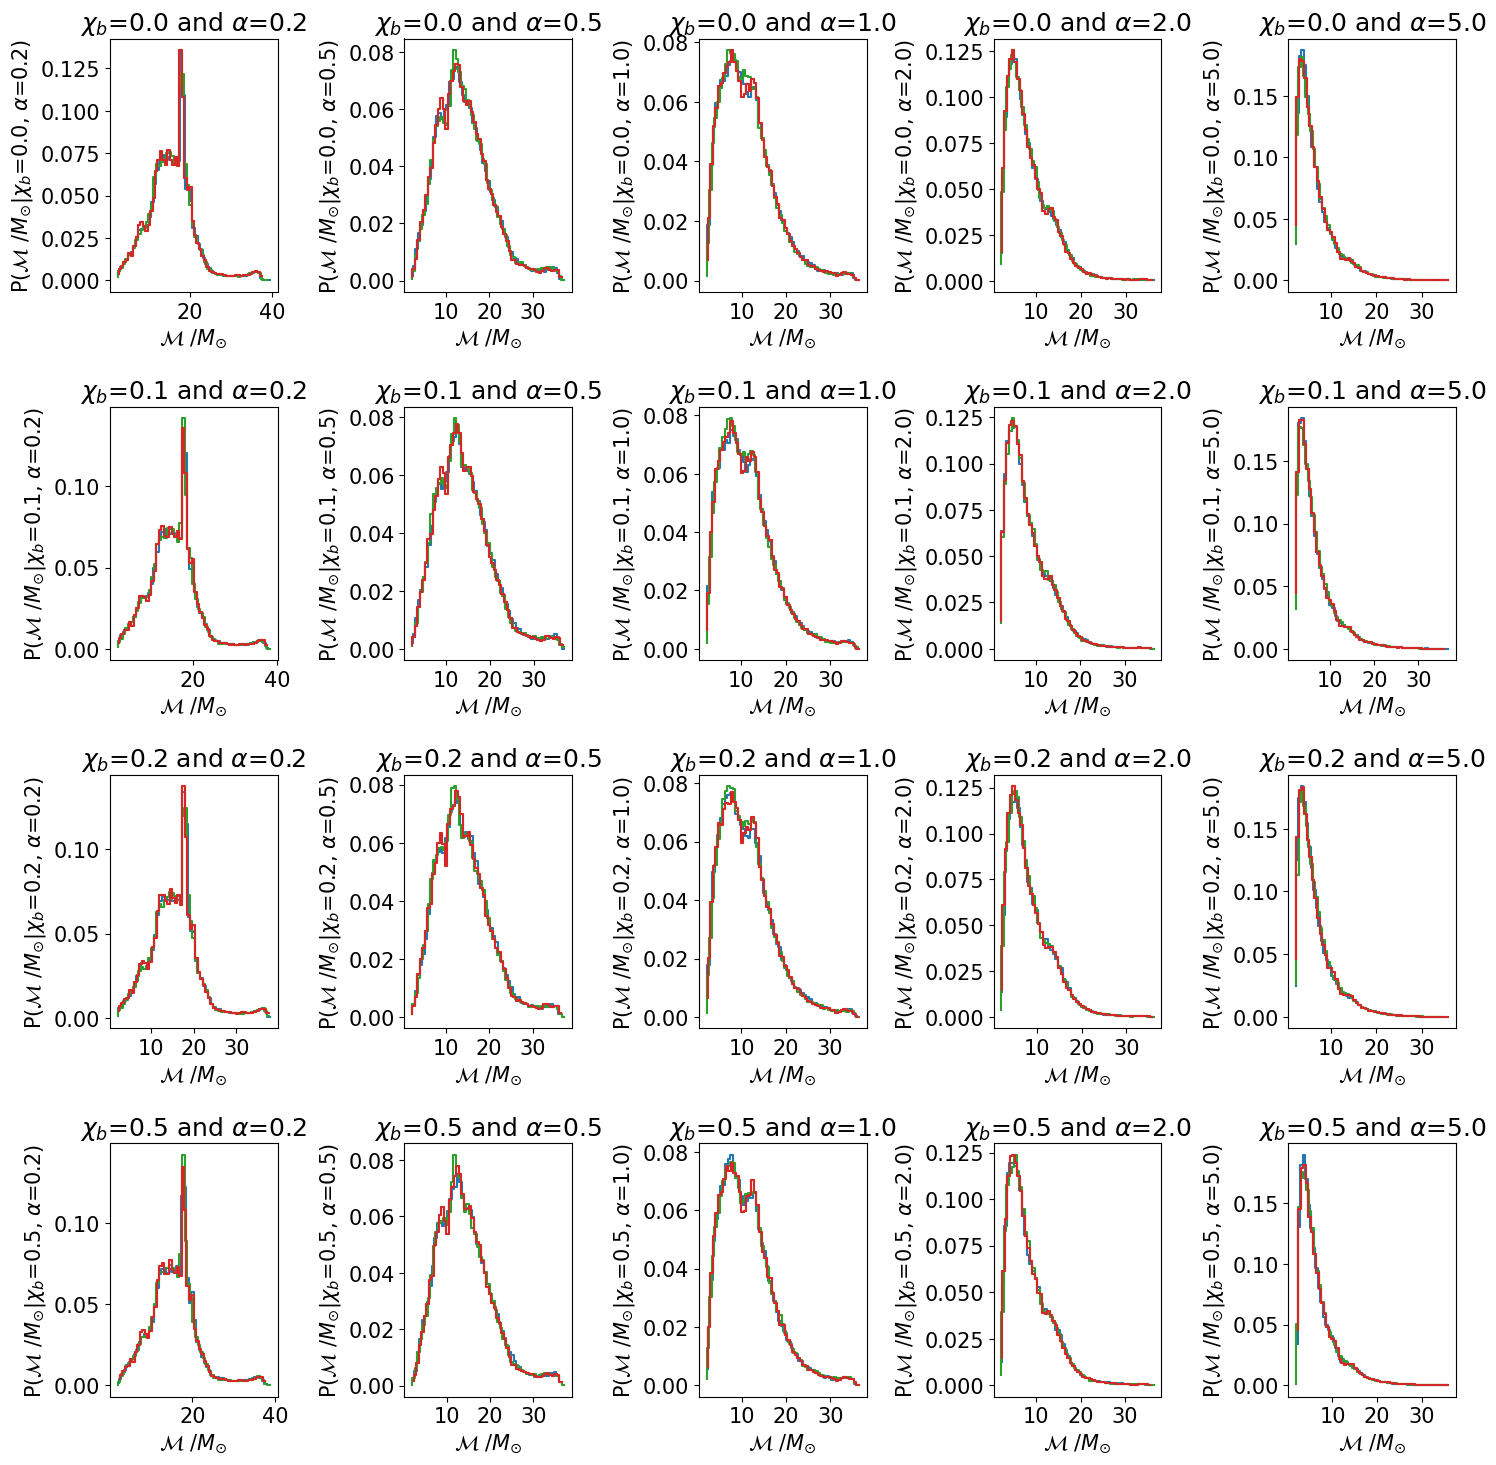

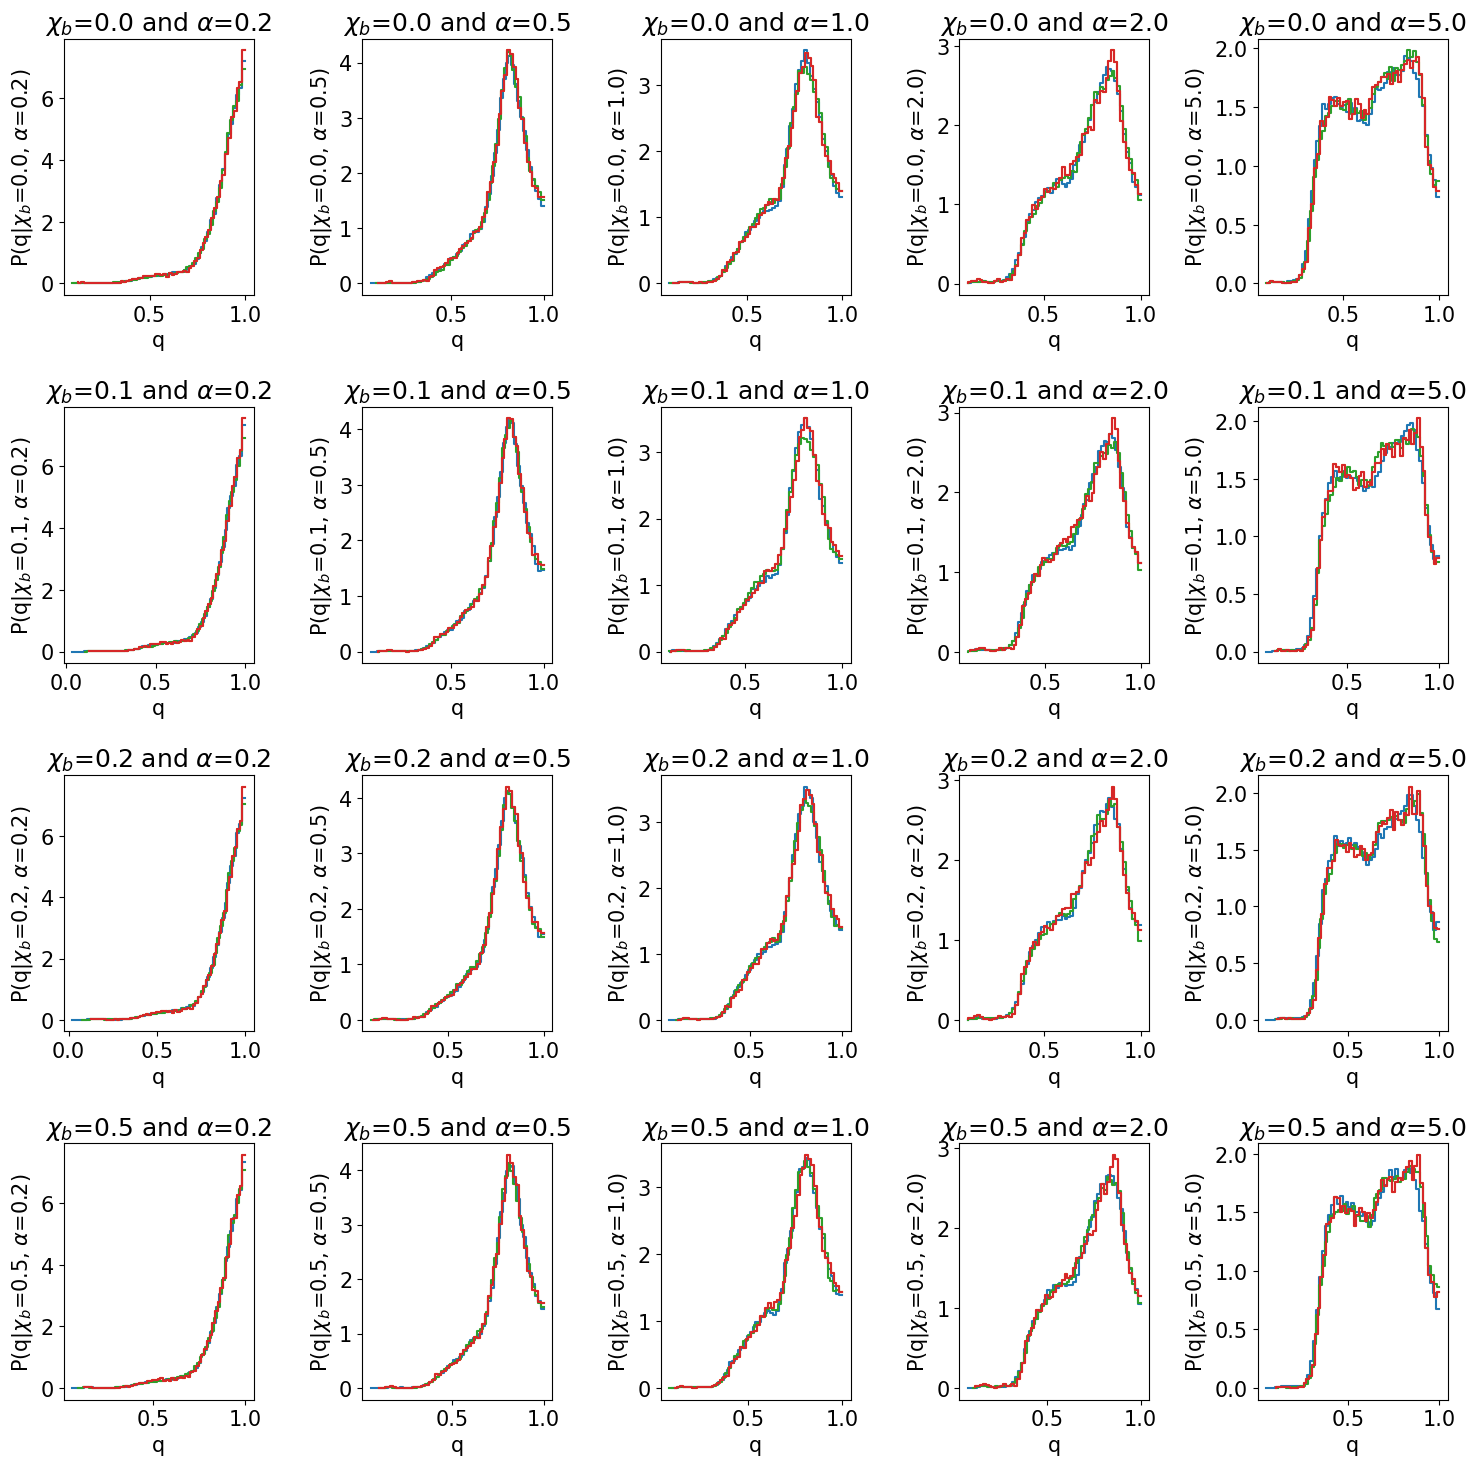

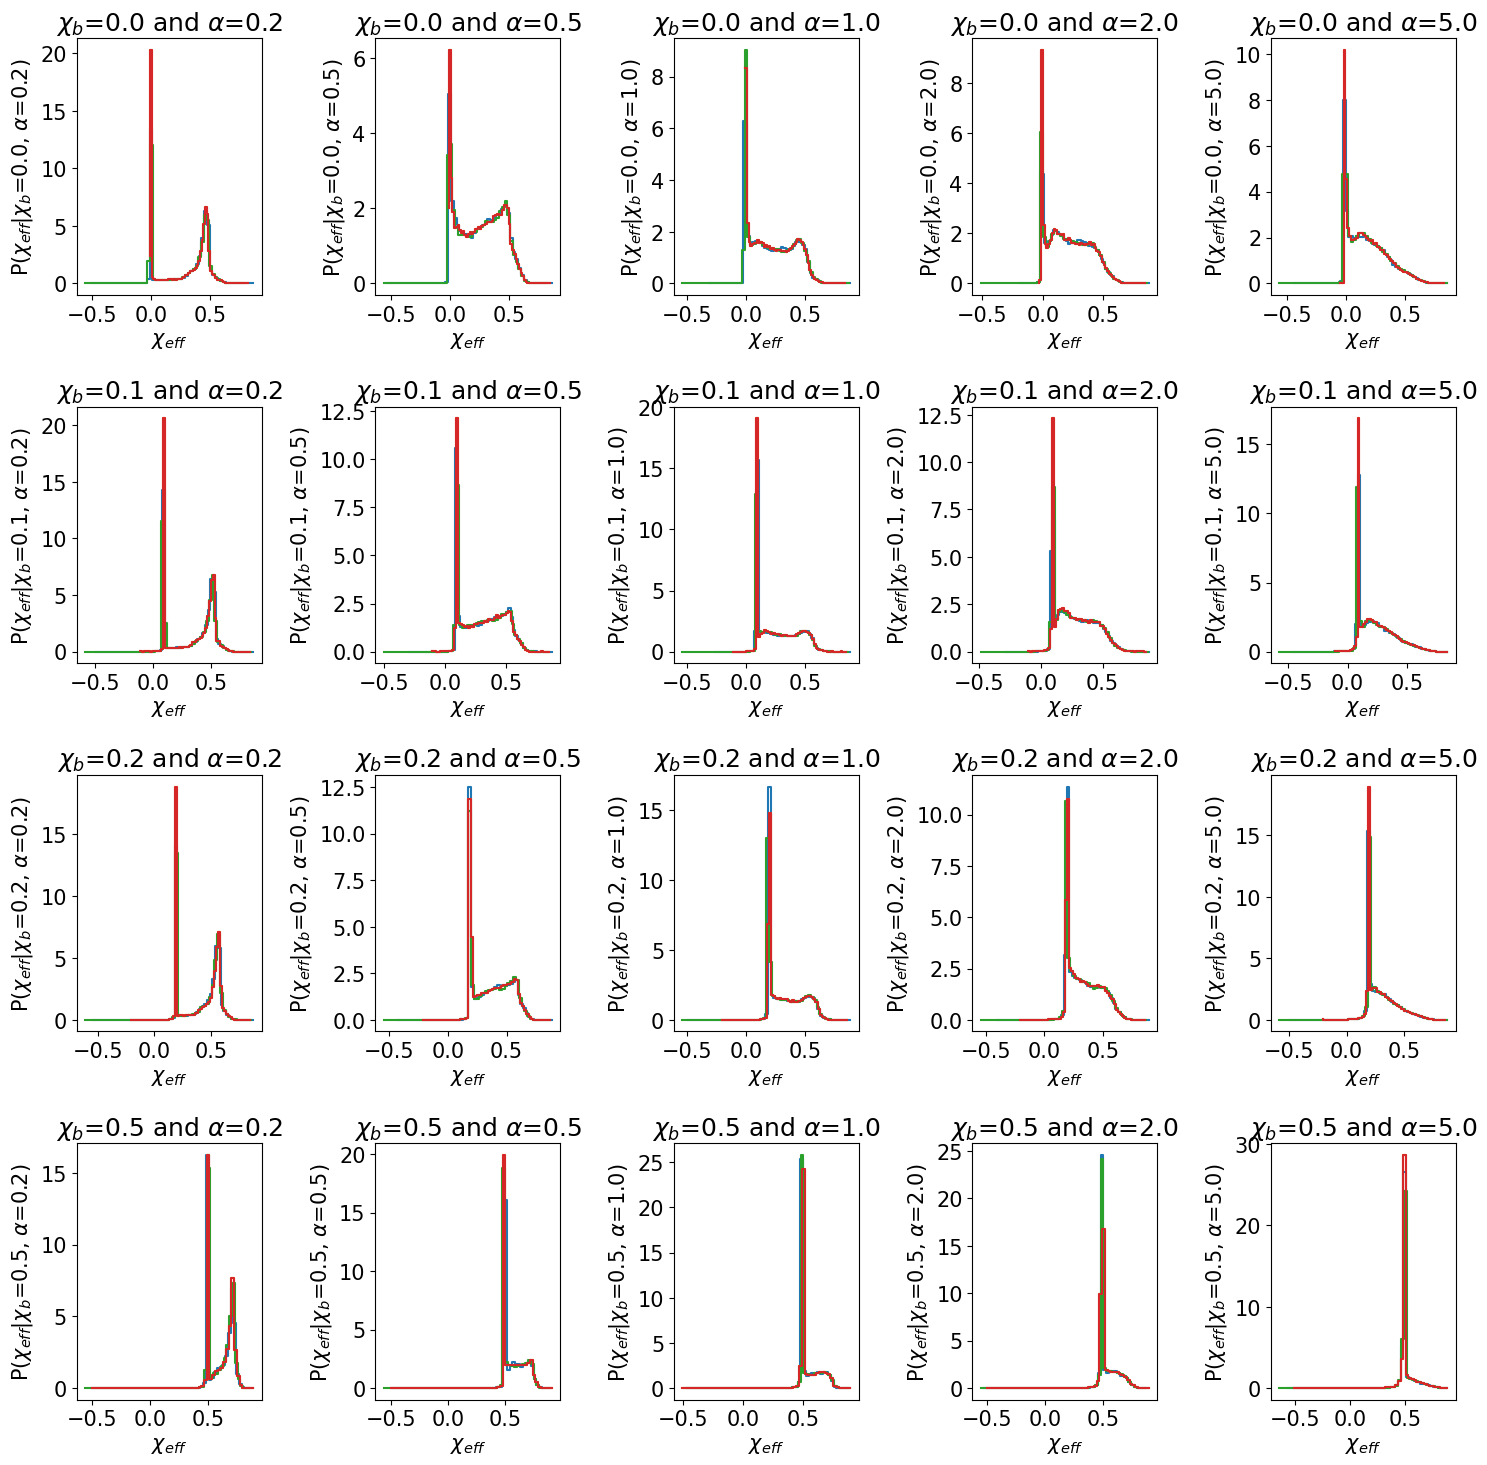

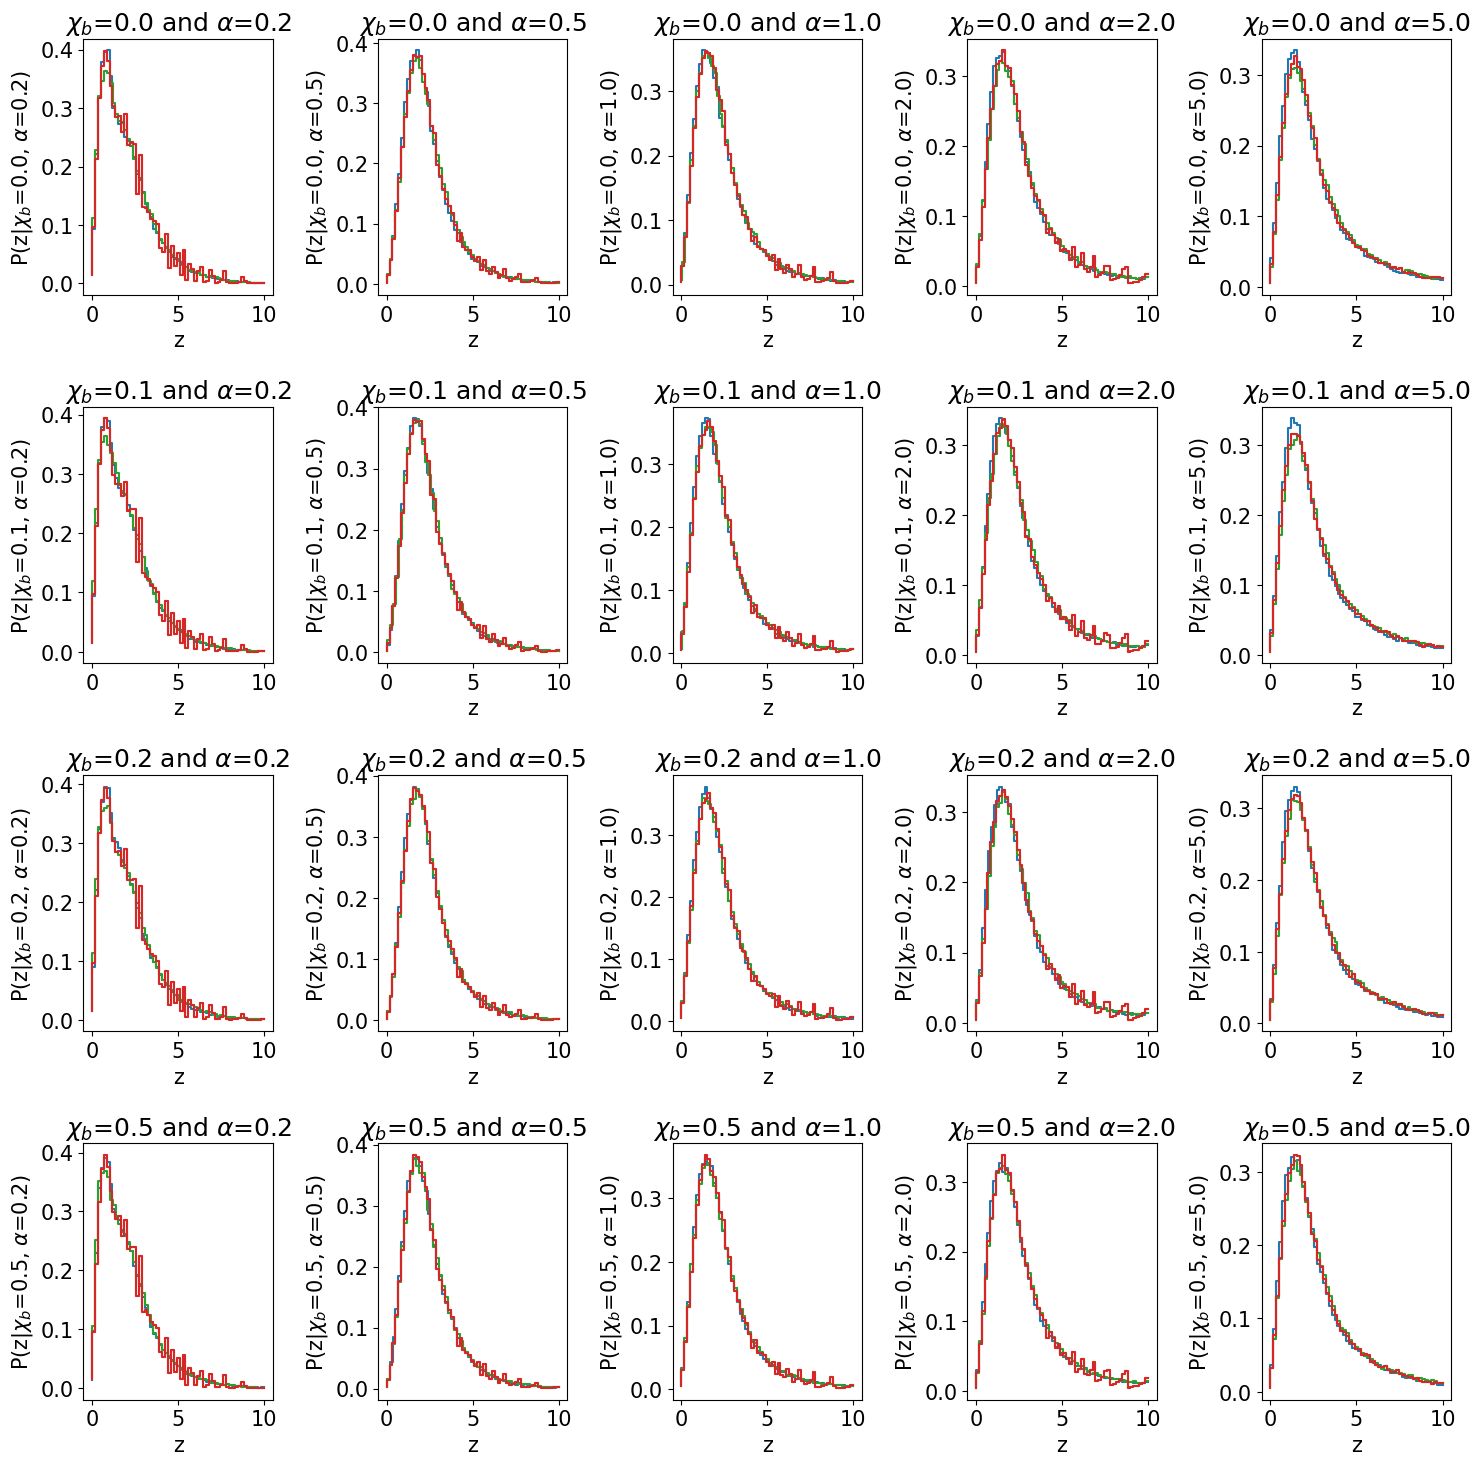

In [19]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
no_samples = 100000
no_bins = 60
alpha_CE = [0.2,0.5,1.0,2.,5.]


fig_mchirp, ax_m = plt.subplots(4,5)
fig_q, ax_q = plt.subplots(4,5)
fig_c, ax_c = plt.subplots(4,5)
fig_z, ax_z = plt.subplots(4,5)

param_label = ['$\mathcal{M}$ /$M_{\odot}$','q', '$\chi_{eff}$', 'z']

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        for i, flow in enumerate([flow1,flow2]):
            if i == 0:
                flow_samples_stack = flow.flow.sample(np.array([xb,np.log(a)]), no_samples)
            else:
                flow_samples_stack = flow.flow.sample(np.array([xb,a]), no_samples)
            flow_mchirp = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
            flow_q = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
            flow_chieff = np.tanh(flow_samples_stack[:,2])
            flow_z = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])

            mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

            for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
                flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
                known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id,alpha_id)][:][param[i]], bins=no_bins, density=True, weights=weights_dict[(chi_b_id,alpha_id)][:])
                ax[chi_b_id,alpha_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')
                ax[chi_b_id,alpha_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
                ax[chi_b_id,alpha_id].set_title(fr'$\chi_b$={xb} and $\alpha$={a}')
                ax[chi_b_id,alpha_id].set_xlabel(fr'{param_label[i]}')
                ax[chi_b_id,alpha_id].set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb}, $\alpha$={a})')
                #ax[chi_b_id,alpha_id].set_yscale('log')
                #ax[chi_b_id,alpha_id].legend()
                fig_mchirp.tight_layout(pad=1.3)
                fig_c.tight_layout(pad=1.3)
                fig_q.tight_layout(pad=1.3)
                fig_z.tight_layout(pad=1.3)

/tmp/ipykernel_3934139/1758812291.py:39: UserWarning: The figure layout has changed to tight
  fig_mchirp.tight_layout(pad=1.3)
/tmp/ipykernel_3934139/1758812291.py:40: UserWarning: The figure layout has changed to tight
  fig_c.tight_layout(pad=1.3)
/tmp/ipykernel_3934139/1758812291.py:41: UserWarning: The figure layout has changed to tight
  fig_q.tight_layout(pad=1.3)
/tmp/ipykernel_3934139/1758812291.py:42: UserWarning: The figure layout has changed to tight
  fig_z.tight_layout(pad=1.3)


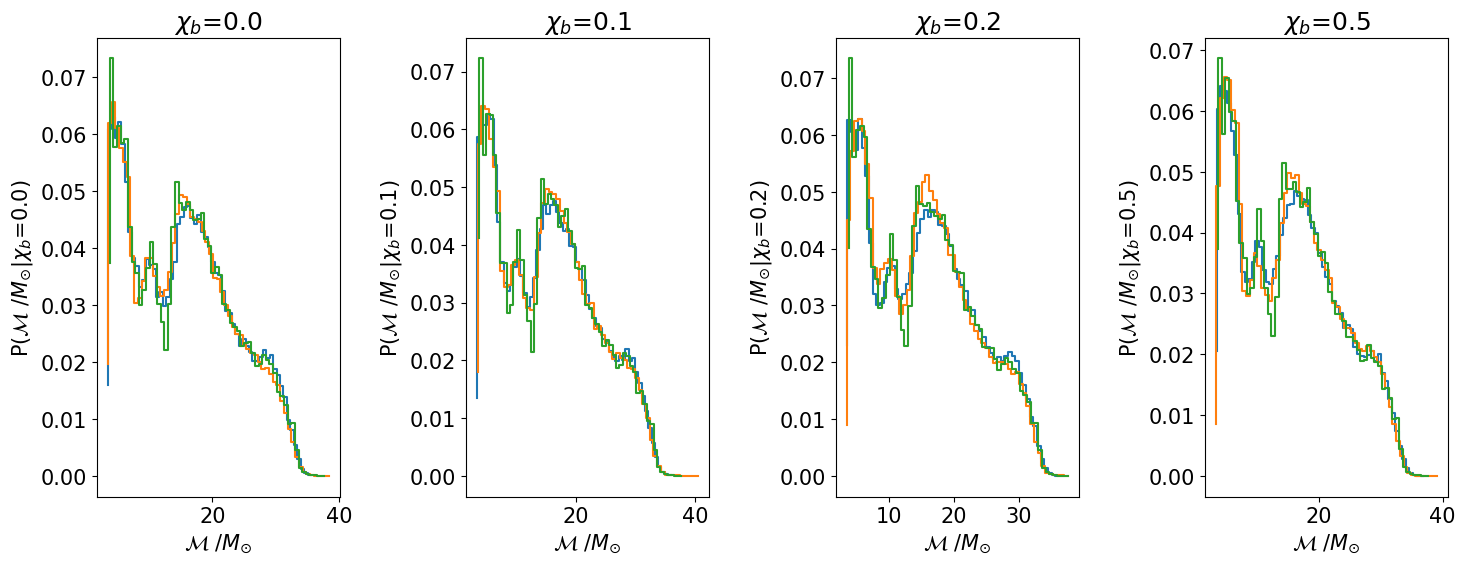

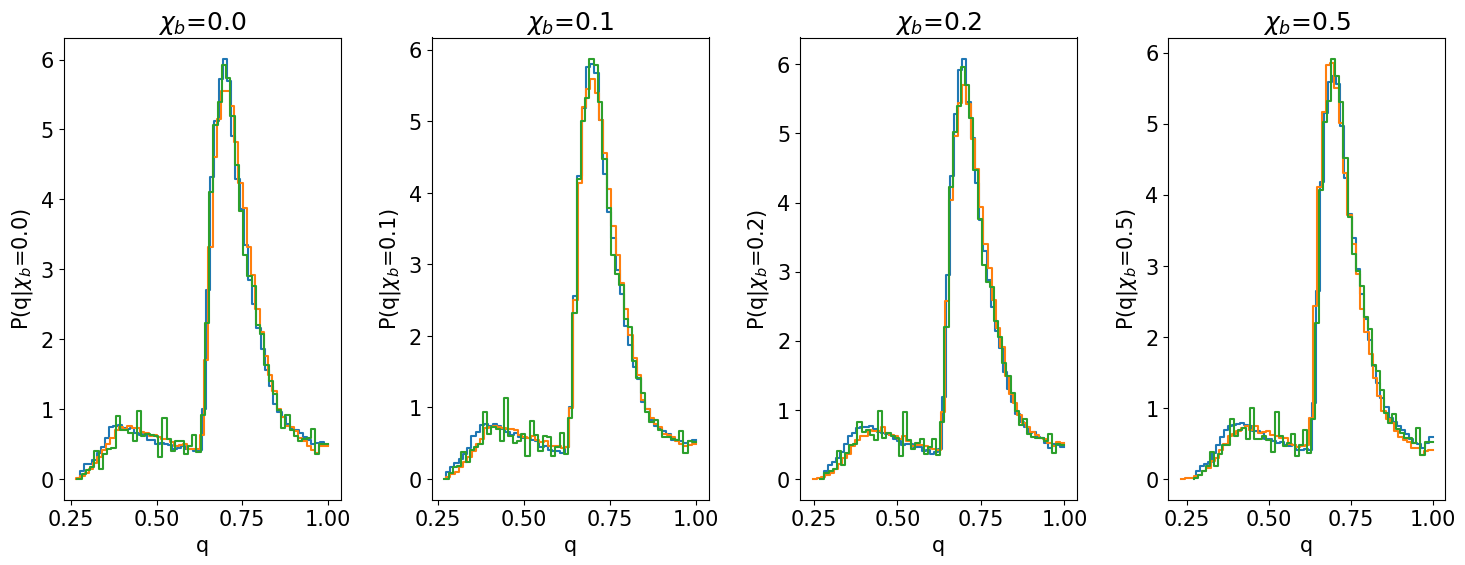

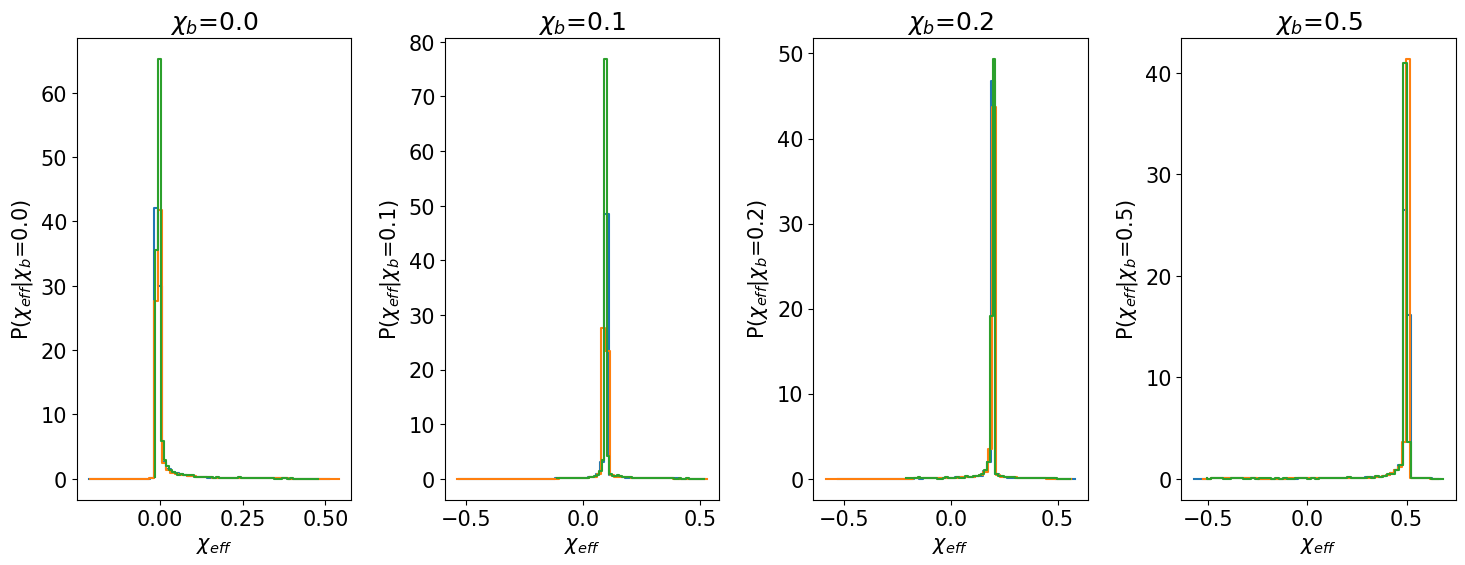

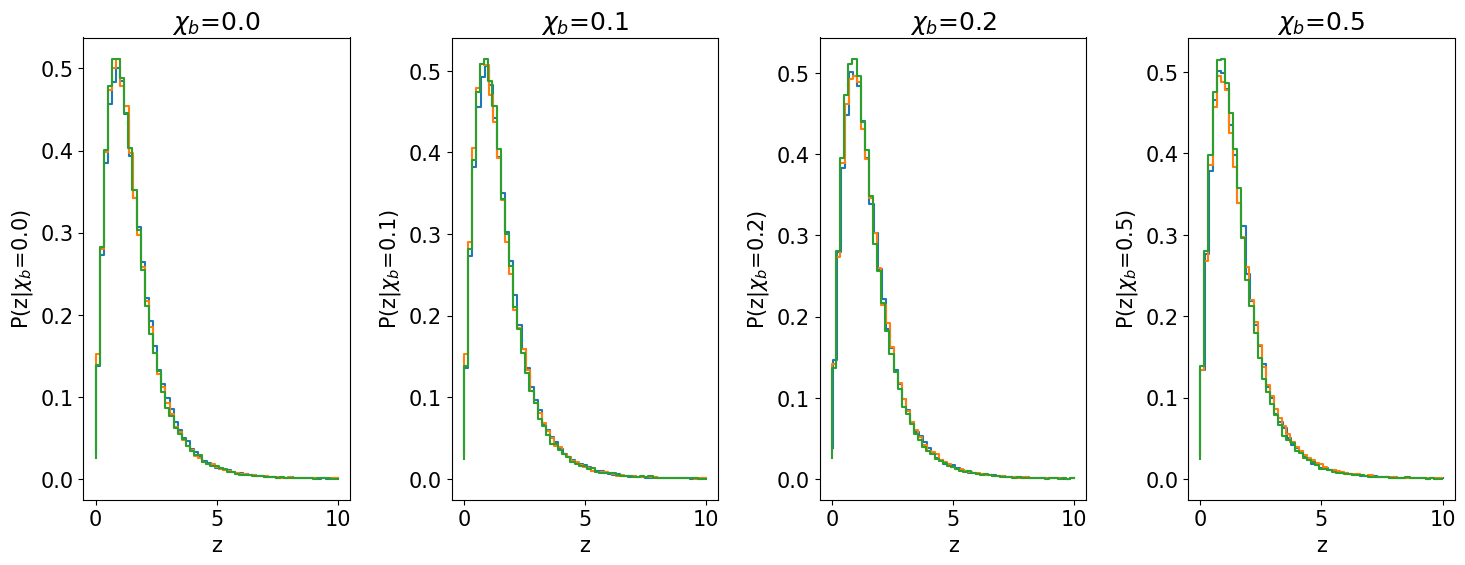

In [10]:
plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams.update({'font.size': 15})
no_samples = 100000
no_bins = 60


fig_mchirp, ax_m = plt.subplots(1,4)
fig_q, ax_q = plt.subplots(1,4)
fig_c, ax_c = plt.subplots(1,4)
fig_z, ax_z = plt.subplots(1,4)

param_label = ['$\mathcal{M}$ /$M_{\odot}$','q', '$\chi_{eff}$', 'z']

for chi_b_id, xb in enumerate(chi_b):
    for i, flow in enumerate([flow1,flow2]):
        flow_samples_stack = flow.flow.sample(np.array([xb]), no_samples)
        flow_mchirp = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
        flow_q = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
        flow_chieff = np.tanh(flow_samples_stack[:,2])
        flow_z = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])

        mapped_flow_samples = [flow_mchirp,flow_q,flow_chieff,flow_z]

        for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
            flow_distr, bin_edges = np.histogram(mapped_flow_samples[i], bins=no_bins, density=True)
            ax[chi_b_id].step(np.linspace(bin_edges[0],bin_edges[-1],no_bins),flow_distr, label='flow')

    for i, ax in enumerate([ax_m,ax_q,ax_c,ax_z]):
        known_distr, bin_edges_known =np.histogram(models_dict[(chi_b_id)][:][param[i]], bins=no_bins, density=True, weights=weights_dict[(chi_b_id)][:])
        ax[chi_b_id].step(np.linspace(bin_edges_known[0],bin_edges_known[-1],no_bins),known_distr,label='underlying')
        ax[chi_b_id].set_title(fr'$\chi_b$={xb}')
        ax[chi_b_id].set_xlabel(fr'{param_label[i]}')
        ax[chi_b_id].set_ylabel(fr'P({param_label[i]}|$\chi_b$={xb})')
        #ax[chi_b_id,alpha_id].set_yscale('log')
        #ax[chi_b_id,alpha_id].legend()
        fig_mchirp.tight_layout(pad=1.3)
        fig_c.tight_layout(pad=1.3)
        fig_q.tight_layout(pad=1.3)
        fig_z.tight_layout(pad=1.3)

In [12]:
corner_kwargs = dict(
    bins=64,
    smooth=0.9,
    color="teal",
    #quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=True,
    hist_kwargs=dict(density=True),
    labels=['mchirp','q','chieff','z']
)

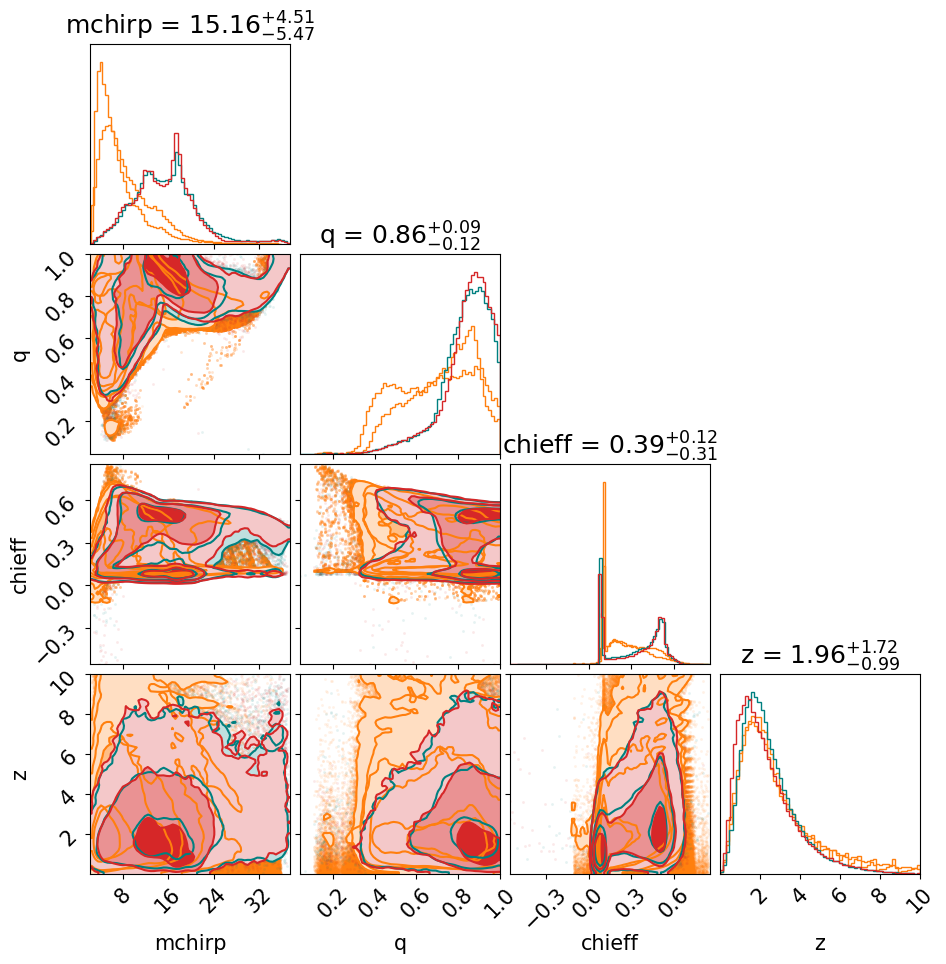

In [28]:
#sample flow
no_samples=100000
hyperparam_idxs = (1,4)
kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"

kwargs2 = deepcopy(corner_kwargs)
kwargs2["color"] = "C3"
kwargs2["hist_kwargs"]["color"] = "C3"

fig =corner.corner(models_dict[hyperparam_idxs], weights=weights_dict[hyperparam_idxs][:], **kwargs)
corner.corner(models_dict[(1,3)], fig=fig, weights=weights_dict[(1,3)][:], **kwargs)


flow_samples_stack_1 = flow1.flow.sample(np.array([0.08,np.log(.3)]),no_samples)
flow_samples_stack_1[:,0] = flow1.expistic(flow_samples_stack_1[:,0], flow1.mappings[0], flow1.mappings[1])
flow_samples_stack_1[:,1] = flow1.expistic(flow_samples_stack_1[:,1], flow1.mappings[2])
flow_samples_stack_1[:,2] = np.tanh(flow_samples_stack_1[:,2])
flow_samples_stack_1[:,3] = flow1.expistic(flow_samples_stack_1[:,3], flow1.mappings[4], flow1.mappings[5])
corner.corner(flow_samples_stack_1.numpy(), fig=fig, **corner_kwargs)


for flow in [flow2]:

    flow_samples_stack = flow.flow.sample(np.array([0.08,.3]),no_samples)
    flow_samples_stack[:,0] = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
    flow_samples_stack[:,1] = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
    flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
    flow_samples_stack[:,3] = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])
    corner.corner(flow_samples_stack.numpy(), fig=fig, **kwargs2)


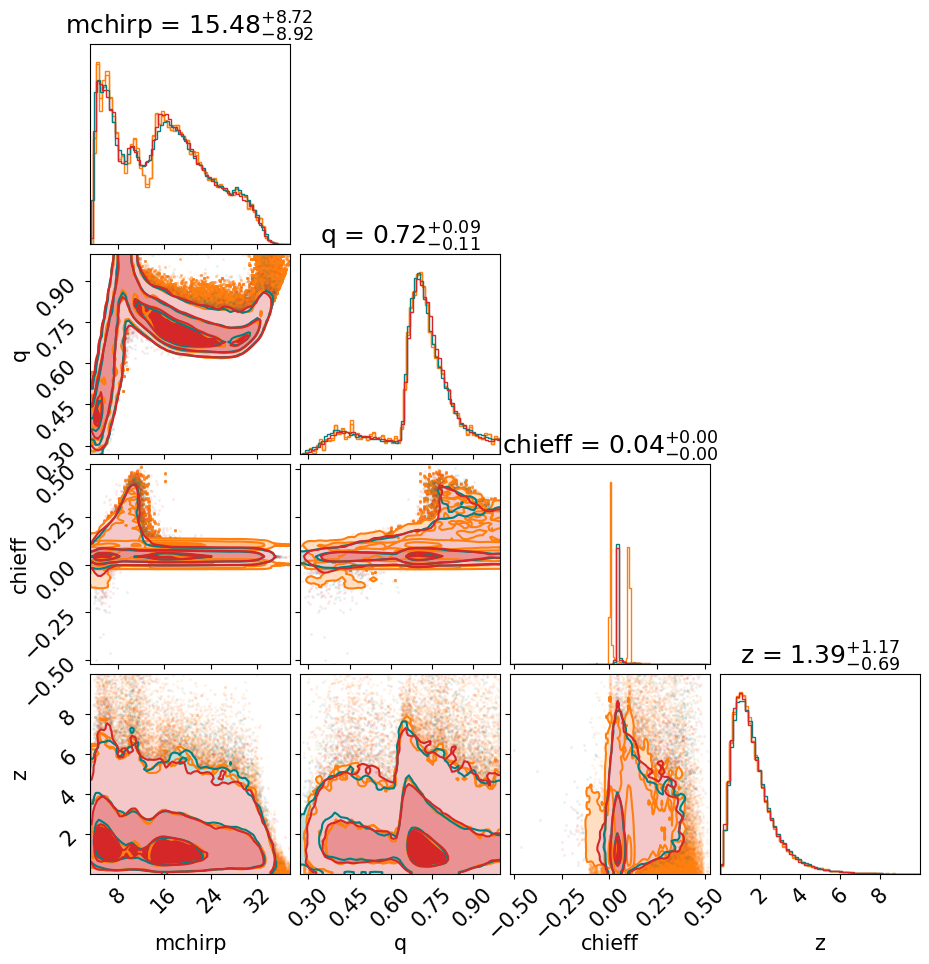

In [17]:
#sample flow
no_samples=100000
hyperparam_idxs = (1)
kwargs = deepcopy(corner_kwargs)
kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"

kwargs2 = deepcopy(corner_kwargs)
kwargs2["color"] = "C3"
kwargs2["hist_kwargs"]["color"] = "C3"

fig =corner.corner(models_dict[hyperparam_idxs], weights=weights_dict[hyperparam_idxs][:], **kwargs)
corner.corner(models_dict[(0)], fig=fig, weights=weights_dict[(0)][:], **kwargs)


for kwargs,flow in zip([corner_kwargs, kwargs2],[flow1, flow2]):

    flow_samples_stack = flow.flow.sample(np.array([0.04]),no_samples)
    flow_samples_stack[:,0] = flow.expistic(flow_samples_stack[:,0], flow.mappings[0], flow.mappings[1])
    flow_samples_stack[:,1] = flow.expistic(flow_samples_stack[:,1], flow.mappings[2])
    flow_samples_stack[:,2] = np.tanh(flow_samples_stack[:,2])
    flow_samples_stack[:,3] = flow.expistic(flow_samples_stack[:,3], flow.mappings[4], flow.mappings[5])
    corner.corner(flow_samples_stack.numpy(), fig=fig, **kwargs)
